## NSMC 정제하기

- Naver Sentimental Movie Corpus
- 감정분석을 위해, Naver Movie Corpus(https://github.com/e9t/nsmc/) 를 사용
- 영화 당 100개의 140자평(=리뷰) 를 초과하지 않는 선에서 수집
- 총 20만개 리뷰 (수집은 64만개)
    - ratings_train.txt : 15만
    - ratings_test.txt : 5만
- 긍정(9 ~ 10점) / 부정(1 ~ 4점) 리뷰의 비율을 동일하게 샘플링 (random guess yields 50% accuracy)
- 보통 리뷰는 긍정은 만점에 많이 쏠리는데 반해 부정에 대한 점수폭이 애매 (최대한 넓게 잡은 이유)
- 중립 리뷰는 포함하지 않음

In [1]:
# 불러올 txt파일은 각각 id, 리뷰, 별점 (각 컬럼은 '탭'으로 구분)
def read_documents(filename):
    with open(filename, encoding='utf-8') as f:
        # .splitlines() : 불러온 파일을 u라인 형태로 split
        documents = [line.split('\t') for line in f.read().splitlines()]
        documents = documents[1:] # 첫출이 카테고리명 -> 제외
    # 결과 return
    return documents
    
train_docs = read_documents("ratings_train.txt")
test_docs = read_documents("ratings_test.txt")

In [2]:
print(len(train_docs)) # 15만개
print(len(test_docs)) # 5만개

150000
50000


### 함수 정의.

#### MeCab 함수 설정

In [3]:
"""
    Parsing 규칙의 문제점, split을 "," 기준으로 하는데, token이 "," 인 경우에는 쉼표만 잘려서 나오기 때문에, 
    + "%," 같이 특수문자와 쉼표가 같이 등장하는 경우도 생각해주어야 함.
    
    (",", "SC") 의 원래 튜플이 만들어지지 않음.
    
    명사 분석의 경우 해당 토큰이 필요하지 않으니 pass
    
    형태소 분석과 POS tagging의 경우 해당 토큰이 필요하므로, token[0]이 ' 인 경우엔 따로 (",", "SC")를 집어 넣어줘야함.
"""
import MeCab # 윈도우 명령어
import re

mecab = MeCab.Tagger()

def mecab_nouns(text):
    nouns = []
    
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+") 
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
        
    # 추출한 token중에 POS가 명사 분류에 속하는 토큰만 선택.
    for token in temp:
        if token[1] == "NNG" or token[1] == "NNP" or token[1] == "NNB" or token[1] == "NNBC" or token[1] == "NP" or token[1] == "NR":
            nouns.append(token[0])
        
    return nouns

def mecab_morphs(text):
    morphs = []
    
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+") 
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
        
    # 추출한 token중에 문자열만 선택.
    for token in temp:
        morphs.append(token[0])
    
    return morphs

def mecab_pos(text):
    pos = []
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+") 
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    pos = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
        
    return pos

#### 텍스트 전처리 함수

In [4]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    return doc

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path) as f:
        for word in f:
            SW.add(word)
            
    return SW

def text_tokenizing(doc):
    return [word for word in mecab_morphs(doc) if word not in SW and len(word) > 1]
    
    # wordcloud를 위해 명사만 추출하는 경우.
    #return [word for word in mecab_nouns(doc) if word not in SW and len(word) > 1]

### 불러온 데이터를 품사 태그를 붙여서 토크나이징합니다.

- 리뷰 등의 소셜 데이터는 고유명사/보통명사 구분해서 얻을 수 있는 정보가 적다.
    - 형태소 분석기가 고유명사를 판별하기가 어렵기 때문
    - 문장 자체도 완벽한 문장이 아니라 인터넷 용어 혹은 축약 하는 경우 다수
    - 그래서 pos를 잘 붙이지 않는다.
    - 형태소 모델의 성능이 좋거나, data가 100만 단위면 해도 괜찮음

In [5]:
import MeCab
from konlpy.tag import Okt
import json
import os
import re
from pprint import pprint

# 둘중 편한 것 사용
# 컴퓨터 성능이 안좋다면 okt 추천
# 20만개 정도면 속도는 거의 비슷
okt = Okt() # 고유/보통 명사 없이 단어 단위로 분석
mecab = MeCab.Tagger()

# 불용어 지정
SW = define_stopwords("stopwords-ko.txt")

"""
데이터가 많아서 연산시간 오래걸림
형태소 분석 결과(train_docs.json) 있으면 바로 load
형태소 분석 결과 없으면 text_tokenizing() 으로 형태소 분석 후 저장
이렇게 해두면 추후 분석을 다시 할때 매번 데이터를 불러와서 정제할 필요가 없다.
"""
# os.exists() : ()안 (경로)에 해당 파일 있는지 확인
if os.path.exists('train_docs.json'): # 형태소 분석한 파일명
    with open("train_docs.json", encoding='utf-8') as f:
        train_data = json.load(f)
# 해당 파일이 없으면 형태소 분석기로 분석
# text_tokenizing에 들어갈 input은 리뷰 : line[1]
# 형태소 분석에 같이 나와야할 값 : label : line[2]
else:
    train_data = [(text_tokenizing(line[1]), line[2]) for line in train_docs if text_tokenizing(line[1])]
# 위의 코드와 동일
#     train_data = []
#     for line in train_docs:
          # 형태소 분석 결과가 없으면 drop
#         if text_tokenizing(line[1]): # review가 있으면 형태소 분석
#             train_data.append((text_tokenzing(line[1]), line[2])) 
    
    # 형태소 분석결과 json으로 저장
    with open("train_docs.json", 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent='\t')

        
if os.path.exists('test_docs.json'):
    with open("test_docs.json", encoding='utf-8') as f:
        test_data = json.load(f)
else:
    test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]
    
    with open("test_docs.json", 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent='\t')

# 결과 출력
pprint(train_data[0])
pprint(test_data[0])

[['진짜', '짜증', '네요', '목소리'], '0']
[['GDNTOPCLASSINTHECLUB'], '0']


### NLTK를 이용한 histogram 분석.

* 데이터 분석을 하기 위해 기본적인 정보들을 확인

* nltk 라이브러리를 이용하여 전처리
    - natural language tool kit
    - 보통 영문에서 많이 쓰임, histogram그릴때 유용함

In [6]:
import nltk

# 토크나이징한 파일 불러오기
# 현 데이터 형태의 doc기준 : 1번째가 리뷰, 2번째가 label
# 일반 for loop으로 doc를 넣으면 튜플로 입력 -> 2중 for loop한 이유
total_tokens = [token for doc in train_data for token in doc[0]]

# train + test를 하려면
#total_tokens = [token for doc in train_data + test_data for token in doc[0]]

print(len(total_tokens))

1206841


In [7]:
# txt사용하기 위한 기본 전처리 함수 'nltk.Text()'
text = nltk.Text(total_tokens, name='NMSC')

# text.tokens : text파일을 토큰화 
# set() : 중복 제거
print(len(set(text.tokens)),'\n') # 전체 토큰 개수

# 출현빈도 TOP 10 단어
pprint(text.vocab().most_common(10))

51722 

[('영화', 57614),
 ('..', 22813),
 ('는데', 11543),
 ('너무', 11002),
 ('정말', 9783),
 ('으로', 9322),
 ('네요', 9053),
 ('재밌', 9022),
 ('지만', 8366),
 ('진짜', 8326)]


- 형태소 분석을 한 파일을 토큰화 했기 때문에 특수문자들이 제거되지 않음
    - '..'이 많다고 나온 이유
    - 위에서 지정한 text_cleaning 함수로 처리해주면 된다.

- 굳이 먼저 지우지 않은 이유
    - 소셜데이터는 한글 제외하고 모두 날리는 식의 전처리는 바람직하지 않음
    - 특수문자(?, !, .... etc)나, 영문, 숫자 표현 모두 의미가 있을 가능성이 큼
    - 따라서 **소셜 데이터는 클리닝 과정없이 먼저 분석결과를 보고 조정하는 것**이 바람직
    - 예를 들어 frequency 체크를 해서 특수문자가 많다면 그 이유를 파악해서 전처리를 할지 유지할지를 선택할 수 있다.
    
- Word Cloud 만들때는 형태소 분석이 아닌 명사분석을 하는 것이 더 바람직할 수 있다.

### Histogram 그리기.

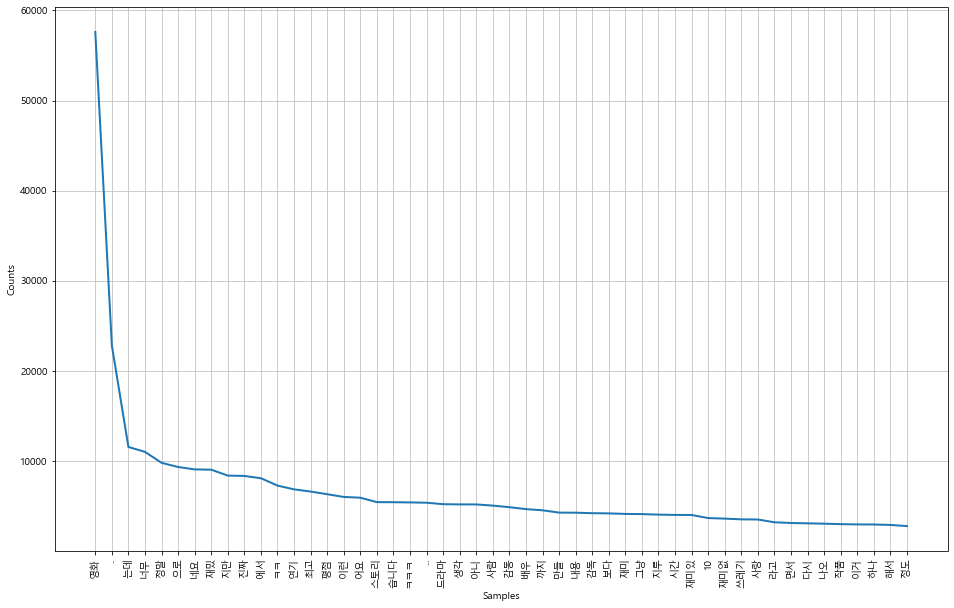

In [8]:
# 필요 라이브러리 load
import matplotlib.pyplot as plt
import platform # 한글
from matplotlib import font_manager, rc
# jupyter에 built-in으로 표기
%matplotlib inline 

# 글꼴 setting
path = "c:/Windows/Fonts/malgun.ttf" # font path 지정
if platform.system() == 'Darwin': # Mac인 경우 폰트 지정
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Window인 경우 폰트 지정
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system')

# 시각화
plt.figure(figsize=(16, 10))
text.plot(50)

### WordCloud 그리기.

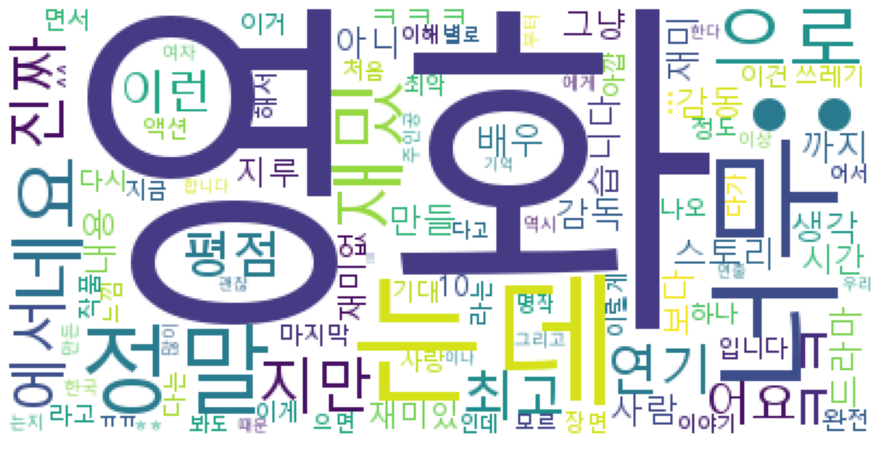

In [12]:
from wordcloud import WordCloud

data = text.vocab().most_common(100)

# 한글의 경우 폰트 경로 지정 필수
font_path='c:/Windows/Fonts/malgun.ttf' # window
wordcloud = WordCloud(font_path=font_path,
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS, # 빼고싶은 단어 지정 
                      background_color='white',
                      ).generate_from_frequencies(dict(data))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off") # matplitlib의 x,y축 지우기
plt.show()

- 형태소 분석으로 시각화 한것이기 때문에 유의미한 결과는 나오지 않음

# 명사분석으로 다시 시각화

In [13]:
# 명사 분석 코드로 재정의
def text_tokenizing(doc):
       return [word for word in mecab_nouns(doc) if word not in SW and len(word) > 1]

In [15]:
# 명사분류기로 다시 토크나이징

train_data = [(text_tokenizing(line[1]), line[2]) for line in train_docs if text_tokenizing(line[1])]
test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]

# 결과 출력
pprint(train_data[0])
pprint(test_data[0])

(['짜증', '목소리'], '0')
(['평점'], '0')


In [16]:
import nltk

# 토크나이징한 파일 불러오기
total_tokens = [token for doc in train_data for token in doc[0]]

print(len(total_tokens))

601167


In [17]:
# txt사용하기 위한 기본 전처리 함수 'nltk.Text()'
text = nltk.Text(total_tokens, name='NMSC')

print(len(set(text.tokens)),'\n') # 전체 토큰 개수

# 출현빈도 TOP 10 단어
pprint(text.vocab().most_common(10))

30915 

[('영화', 57614),
 ('연기', 6835),
 ('최고', 6595),
 ('평점', 6297),
 ('스토리', 5422),
 ('드라마', 5192),
 ('생각', 5168),
 ('사람', 5035),
 ('감동', 4860),
 ('배우', 4450)]


## histogram 그리기

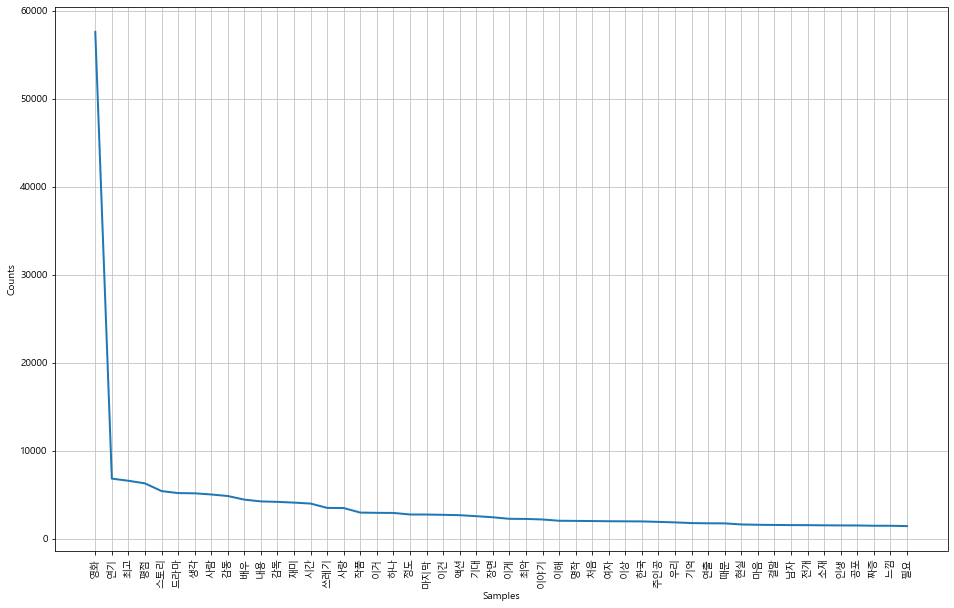

In [18]:
# 필요 라이브러리 load
import matplotlib.pyplot as plt
import platform # 한글
from matplotlib import font_manager, rc
# jupyter에 built-in으로 표기
%matplotlib inline 

# 글꼴 setting
path = "c:/Windows/Fonts/malgun.ttf" # font path 지정
if platform.system() == 'Darwin': # Mac인 경우 폰트 지정
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Window인 경우 폰트 지정
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system')

# 시각화
plt.figure(figsize=(16, 10))
text.plot(50)

## Word Cloud

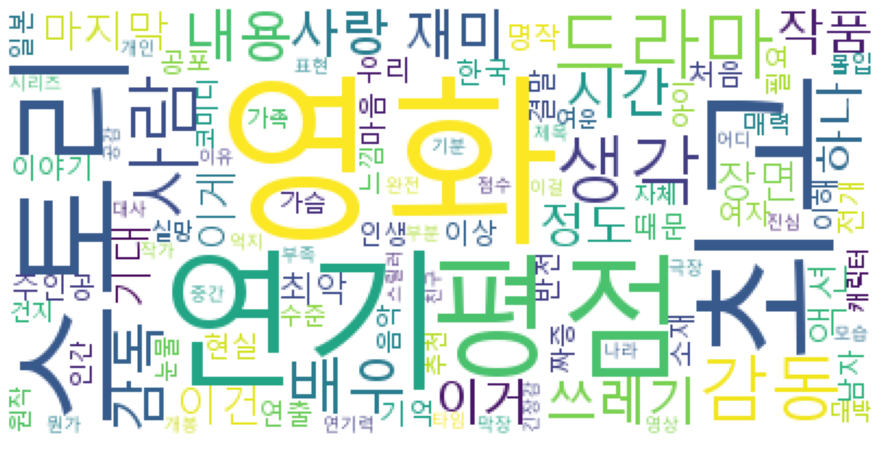

In [19]:
from wordcloud import WordCloud

data = text.vocab().most_common(100)

# 한글의 경우 폰트 경로 지정 필수
font_path='c:/Windows/Fonts/malgun.ttf' # window
wordcloud = WordCloud(font_path=font_path,
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS, # 빼고싶은 단어 지정 
                      background_color='white',
                      ).generate_from_frequencies(dict(data))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off") # matplitlib의 x,y축 지우기
plt.show()